# Double-Sided Crystal Ball Signal Fit
This notebook fits the double-sided crystal ball function to the Monte-Carlo simulated signal events. Only pure category 10 and category 50 events are used as these are the 'best' quality signal events. The fit routines will be a least-squares (technically a chi-square as we will include errors) and a maximum likelihood fit.

In [1]:
# Gather the necessary libraries needed
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import uproot as up

In [2]:
sname = "/disk/moose/lhcb/djdt/Lb2L1520mueTuples/MC/2016MD/fullSampleOct2021/job207-CombDVntuple-15314000-MC2016MD_Full-pKmue-MC.root"
with up.open(sname + ":DTT1520me/DecayTree") as f:
    df = f.arrays(['Lb_M', 'Lb_BKGCAT'], library='pd')
    df = df.sample(frac=1, random_state=0)
    df = df[~df.index.duplicated(keep='first')]

In [3]:
df['cat'] = np.where(df['Lb_BKGCAT'].isin([10, 50]), 1, 0)
# Create a category column which is based on the BKGCAT value 1 = signal, 0 = non-signal
df.drop('Lb_BKGCAT', axis=1, inplace=True)
# Now remove the BKGCAT column, it is redundant now
df = df[df['cat'] == 1]

In [4]:
df.drop(['cat'], inplace=True, axis=1)
df.head()

,Lb_M
57429,5562.917939
90819,5609.557202
102912,5634.664143
72651,5544.834894
67569,5248.033155


## Plotting Initial Mass Distribution
Now we will plot the initial mass distribution for the events we care about, that is signal category 1 events. This is just so we know what we are working with. Errors are computed assuming Poisson statistics that is $\sigma\propto\sqrt{N}$.

In [17]:
low_mass_limit, high_mass_limit = 4000, 6500
no_bins = 100
bins = np.linspace(low_mass_limit, high_mass_limit, no_bins+1)
# Create an array of bin edges

bin_centres = [np.mean(bins[i:i+2]) for i in range(len(bins)-1)]
bin_width = bins[1]- bins[0]

data = df[df['Lb_M'].between(low_mass_limit, high_mass_limit)]

f, _ = np.histogram(df['Lb_M'], bins=bins)
err = np.sqrt(f)
# The error is the square root of the frequency

d = np.array([bin_centres, f, err]).T
# Make an array of the bin centroid the frequency and the associated error

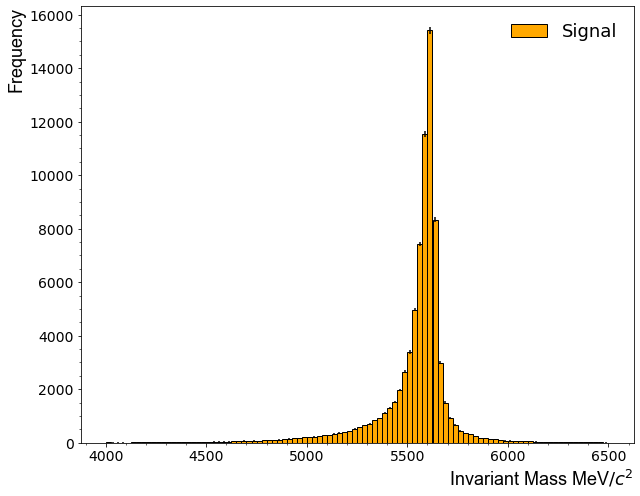

In [18]:
from matplotlib.ticker import AutoMinorLocator

fig, ax = plt.subplots(1, 1, figsize=(9, 7))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
fig.patch.set_facecolor('#FFFFFF')
fonts = {'fontname':'Arial', 'fontsize': 18}

ax.bar(d[:,0], d[:,1], width=bin_width, yerr=d[:,2], label='Signal', edgecolor='k', color='#FFA800')

plt.ylabel('Frequency', horizontalalignment='right', y=1.0, **fonts)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel(r'Invariant Mass MeV$/c^2$', horizontalalignment='right', x=1.0, **fonts)
plt.legend(loc='upper right', ncol=1, fancybox=False, shadow=True, frameon=False, fontsize=18)
plt.tight_layout()
#plt.savefig('../images/signalfits/SigMassDistribution_PresentReadyNotNormed.png', dpi=800)
plt.show()

## Preparation for Fitting the DSCB
Now we have plotted these data we will now attempt to fit them using a statistically sound routine(s). Before fitting we need to remove all the bins with zero frequency and hence zero error to prevent issues when doing math.

Secondly the DSCB is a probabilty distribution as such we should normalise the values associated with the previously computed histogram.

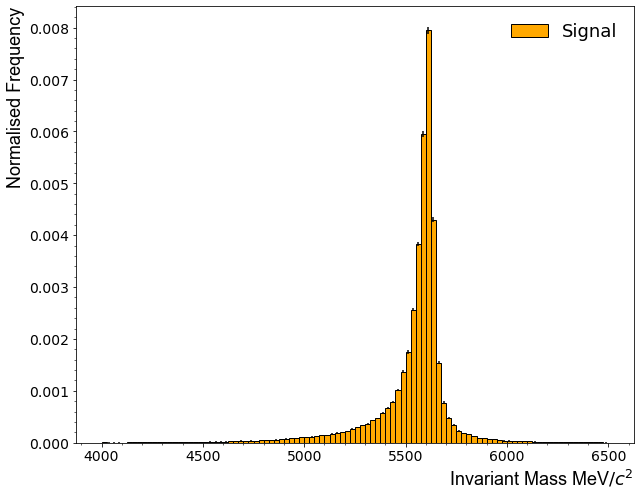

In [19]:
f_norm, _ = np.histogram(df['Lb_M'], bins=bins, density=True)
err_norm = err / (max(f)/max(f_norm))
# The error is the square root of the frequency

d_norm = np.array([bin_centres, f_norm, err_norm]).T
# Make an array of the bin centroid the frequency and the associated error

d_norm = d_norm[d_norm[:,1]!=0,:]
# Remove all the bins with no signal candidates recorded

fig, ax = plt.subplots(1, 1, figsize=(9, 7))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
fig.patch.set_facecolor('#FFFFFF')
fonts = {'fontname':'Arial', 'fontsize': 18}

ax.bar(d_norm[:,0], d_norm[:,1], width=bin_width, yerr=d_norm[:,2], label='Signal', edgecolor='k', color='#FFA800')

plt.ylabel('Normalised Frequency', horizontalalignment='right', y=1.0, **fonts)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel(r'Invariant Mass MeV$/c^2$', horizontalalignment='right', x=1.0, **fonts)
plt.legend(loc='upper right', ncol=1, fancybox=False, shadow=True, frameon=False, fontsize=18)
plt.tight_layout()
#plt.savefig('../images/signalfits/SigMassDistribution_PresentReady.png', dpi=800)
plt.show()

## Defining and Fitting
Now we have scaled our data and errors down appropriately with some, unseen but calculated, scale factor. We now need to define the DSCB function and try to fit it!

In [20]:
def dscb(x, mu, sigma, alow, ahigh, nlow, nhigh):
    # See https://arxiv.org/pdf/2011.07560.pdf
    import numpy as np
    z = (x - mu)/sigma
    values = []
    
    # Apply a specific function to the shifted values based on initial values
    for v in z:
        fx = 0
        if v < -alow:
            fx = np.exp(-0.5 * (alow**2)) * (((alow/nlow) * (nlow/alow - alow - v))**(-nlow))
        elif v > ahigh:
            fx = np.exp(-0.5 * (ahigh**2)) * (((ahigh/nhigh) * (nhigh/ahigh - ahigh + v))**(-nhigh))
        else:
            fx = np.exp(-0.5 * (v**2))
        values.append(fx)
    values = np.array(values)
    x_gaps = np.array([x[i+1] - x[i] for i in range(0, len(x)-1)])
    # The widths of each 'bin' that the function is being evaluated over
    mean_values = np.array([np.mean([values[i], values[i+1]]) for i in range(len(values)-1)])
    
    N = 1/np.sum(np.multiply(x_gaps, mean_values))
    #print(f'Scaling factor: {N}\nNormalised: {np.sum(N*values)}')
    return N * values# Works but needs some serious optimisation
    

In [9]:
from scipy.optimize import curve_fit

popt, pcov = curve_fit(dscb, d_norm[:,0], d_norm[:,1], p0=[5600, 40, 0.7, 1.43, 5.01, 5.13], sigma=d_norm[:,2])

/tmp/ipykernel_3081381/1331268361.py:11: RuntimeWarning: invalid value encountered in double_scalars
  fx = np.exp(-0.5 * (alow**2)) * (((alow/nlow) * (nlow/alow - alow - v))**(-nlow))
/tmp/ipykernel_3081381/1331268361.py:13: RuntimeWarning: invalid value encountered in double_scalars
  fx = np.exp(-0.5 * (ahigh**2)) * (((ahigh/nhigh) * (nhigh/ahigh - ahigh + v))**(-nhigh))


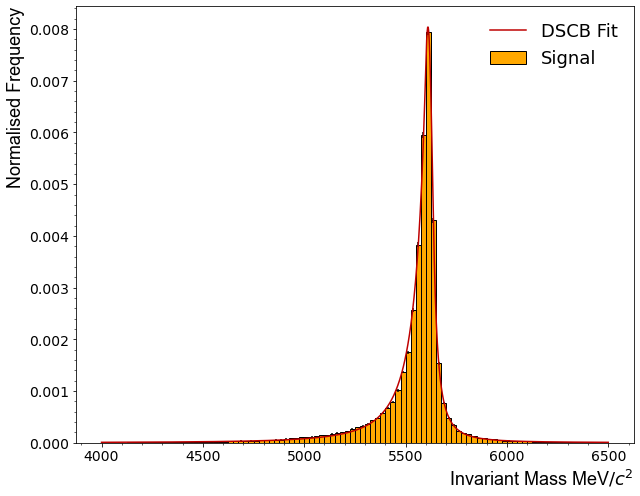

In [21]:
masses = np.linspace(4000, 6500, 1000)

fig, ax = plt.subplots(1, 1, figsize=(9, 7))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
fig.patch.set_facecolor('#FFFFFF')
fonts = {'fontname':'Arial', 'fontsize': 18}

ax.bar(d_norm[:,0], d_norm[:,1], width=bin_width, yerr=d_norm[:,2], label='Signal', edgecolor='k', color='#FFA800')
ax.plot(masses, dscb(masses, *popt), label='DSCB Fit $\chi^2=1.077$', color='#bf0000')

plt.ylabel('Normalised Frequency', horizontalalignment='right', y=1.0, **fonts)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel(r'Invariant Mass MeV$/c^2$', horizontalalignment='right', x=1.0, **fonts)
plt.legend(loc='upper right', ncol=1, fancybox=False, shadow=True, frameon=False, fontsize=18)
plt.tight_layout()
plt.savefig('../images/signalfits/SigMassDistributionDSCBFit_PresentReady.png', dpi=800)
plt.show()

Great news! We have a fit using a least-squares routines with errors on the parameters. Now let us calculate a chi-square per d.o.f on this fit.

In [11]:
# Re-scale the data back up to normal frequencey range
y_pred = dscb(masses, *popt)
scaled_y_pred = y_pred * (max(f)/max(f_norm))

In [24]:
from scipy.stats import chi2
from scipy.stats import ks_2samp

preds = dscb(d[:,0], *popt) * (max(f)/max(f_norm))

chi = np.sum(((d[:,1]-preds)/d[:,2]**2)**2)
chi, chi2.ppf(0.05, df=len(preds)-6)

(78.28146536578741, 72.63976778588469)

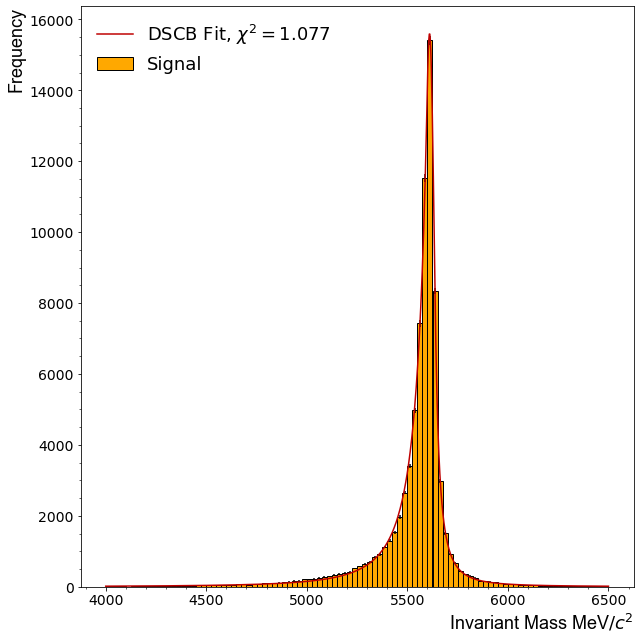

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
fig.patch.set_facecolor('#FFFFFF')
fonts = {'fontname':'Arial', 'fontsize': 18}

ax.bar(d[:,0], d[:,1], width=bin_width, yerr=d[:,2], label='Signal', edgecolor='k', color='#FFA800')
ax.plot(masses, scaled_y_pred, label=r'DSCB Fit, $\chi^2=1.077$', color='#bf0000')

plt.ylabel('Frequency', horizontalalignment='right', y=1.0, **fonts)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel(r'Invariant Mass MeV$/c^2$', horizontalalignment='right', x=1.0, **fonts)
plt.legend(loc='upper left', ncol=1, fancybox=False, shadow=True, frameon=False, fontsize=18)
plt.tight_layout()
plt.savefig('../images/signalfits/SigMassDistributionDSCBFit_PresentReady.png', dpi=800)
plt.show()

In [13]:
e = np.sqrt(np.diag(pcov))
for j, i in enumerate(popt):
    print(f'Value: {i:.3f} +/- {e[j]:.3f}')

Value: 5610.364 +/- 1.051
Value: 24.224 +/- 1.195
Value: 0.476 +/- 0.028
Value: 1.191 +/- 0.050
Value: 2.704 +/- 0.080
Value: 2.055 +/- 0.085


In [14]:
f = open('DSCB_Fit_Parameters.txt', 'w')
for j, i in enumerate(popt):
    writeable = f'{i} +/- {e[j]}\n'
    f.write(writeable)
f.close()

## Maximum Likelihood Estimation
Now we perform a parameter estimation using a maximum-likelihood estimation technique. This technique is far more common in the physical sciences.

In [67]:
from scipy.stats import poisson
import sys
from scipy.stats import norm
from scipy.optimize import minimize
sys.path.append('../')
import utilities as ut

In [73]:
freqs, data = d_norm[:,0], d_norm[:,1]

def log_likelihood_fast(mu, s, alow, ahigh, nlow, nhigh, f=freqs, d=data):
    m = ut.Model.dscb(f, mu, s, alow, ahigh, nlow, nhigh)
    return np.sum(poisson(m).logpmf(d))

def log_prior(mu, s, alow, ahigh, nlow, nhigh, mux=5700, mum=5500, sx=30, sm=20, alowx=1., alowm=0.2, ahighx=2, ahighm=1, nlowx=3, nlowm=2, nhighx=3, nhighm=2):
    """
    P(mu, sigma, alow, ahigh, nlow, nhigh)
    """
    mu_logp = -np.log(mu) - np.log(np.log(mux/mum))
    s_logp = -np.log(s) - np.log(np.log(sx/sm))
    alow_lp = -np.log(alow) - np.log(np.log(alowx/alowm))
    ahigh_lp = -np.log(ahigh) - np.log(np.log(ahighx/ahighm))
    nlow_lp = -np.log(nlow) - np.log(np.log(nlowx/nlowm))
    nhigh_lp = -np.log(nhigh) - np.log(np.log(nhighx/nhighm))
    return mu_logp + s_logp + alow_lp + ahigh_lp + nlow_lp + nhigh_lp

def log_posterior(mu, s, alow, ahigh, nlow, nhigh, f=freqs, d=data):
    return (log_likelihood_fast(mu, s, alow, ahigh, nlow, nhigh, f=f, d=d)+log_prior(mu, s, alow, ahigh, nlow, nhigh))

In [74]:
from scipy.optimize import minimize

x0 = (5600, 27, 0.5, 1.2, 2.9, 2.2)
sol = minimize(lambda x: -log_posterior(x[0], x[1], x[2], x[3], x[4], x[5]), x0)
sol

      fun: inf
 hess_inv: array([[1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1]])
      jac: array([nan, nan, nan, nan, nan, nan])
  message: 'NaN result encountered.'
     nfev: 7
      nit: 0
     njev: 1
   status: 3
  success: False
        x: array([5.6e+03, 2.7e+01, 5.0e-01, 1.2e+00, 2.9e+00, 2.2e+00])

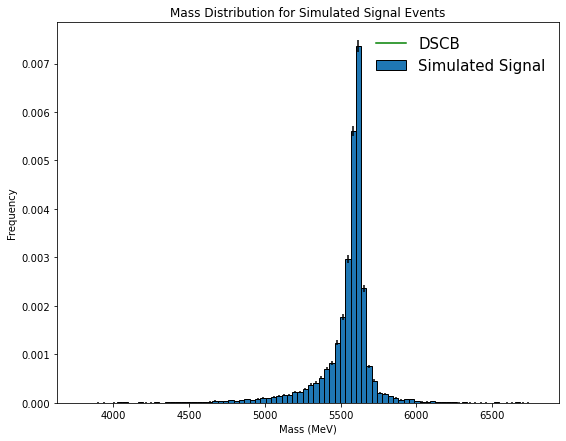

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7))
ax.bar(d_norm[:,0], d_norm[:,1], width=bin_width, yerr=d_norm[:,2], label='Simulated Signal', edgecolor='k', color='#1f77b4')
ax.plot(masses, my_func(masses, *sol['x']), label='DSCB', color='green')
ax.set_ylabel('Frequency')
ax.set_xlabel('Mass (MeV)')
plt.title('Mass Distribution for Simulated Signal Events')
plt.legend(frameon=False, prop={'size': 15})
plt.show()